In [2]:
!pip install yt-dlp
!pip install webvtt-py==0.4.6

In [3]:
import pandas as pd
import yt_dlp
import glob
import re
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [7]:
URLS = ['https://www.youtube.com/watch?v=cUUuRK3Rm4k']

ydl_opts = {#'format':'ba[ext=m4a]/ba[ext=mp4]',
                    #'overwrites' : True,
                    #'extract-audio':False,
                    #'audio-format':'wav',
                    'writesubtitles':True,

                    'writeautomaticsub': True, #This will retrieve the YT-generated Automatic Speech Recognition transcript (not manual transcripts/captions)
                    'subtitleslangs': ['en','live_chat'],
                    'outtmpl': '/content/%(uploader)s/%(upload_date)s--%(id)s--%(title)s.%(ext)s', #Here we are using yt-dl syntax to capture the channel name, upload date, video id, video title, and file extension
                    'skip_download':True,
                    #'ignoreerrors': True,
}
    # ℹ️ See help(yt_dlp.postprocessor) for a list of available Postprocessors and their arguments
    #'postprocessors': [{  # Extract audio using ffmpeg
    #    'key': 'FFmpegExtractAudio',
    #    'preferredcodec': 'm4a',
    #}]
#}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    error_code = ydl.download(URLS)

[youtube] Extracting URL: https://www.youtube.com/watch?v=cUUuRK3Rm4k
[youtube] cUUuRK3Rm4k: Downloading webpage
[youtube] cUUuRK3Rm4k: Downloading ios player API JSON
[youtube] cUUuRK3Rm4k: Downloading android player API JSON
[youtube] cUUuRK3Rm4k: Downloading m3u8 information
[info] cUUuRK3Rm4k: Downloading subtitles: en, live_chat
[info] cUUuRK3Rm4k: Downloading 1 format(s): 248+251
[info] Writing video subtitles to: /content/PewDiePie/20240322--cUUuRK3Rm4k--First Stream In Forever! ⧸ Haunted House Reaction ⧸ Alone in The Dark ⧸ Chatting ⧸.en.vtt
[download] Destination: /content/PewDiePie/20240322--cUUuRK3Rm4k--First Stream In Forever! ⧸ Haunted House Reaction ⧸ Alone in The Dark ⧸ Chatting ⧸.en.vtt
[download] 100% of  565.68KiB in 00:00:00 at 1.43MiB/s
Deleting existing file /content/PewDiePie/20240322--cUUuRK3Rm4k--First Stream In Forever! ⧸ Haunted House Reaction ⧸ Alone in The Dark ⧸ Chatting ⧸.live_chat.json
[info] Writing video subtitles to: /content/PewDiePie/20240322--cUUuRK

In [9]:
json_path = glob.glob("/content/*/*.live_chat.json")
vtt_path =  glob.glob("/content/*/*.en.vtt")
json_data = pd.read_json(json_path[0],
                    orient='records',
                    lines=True)

In [10]:
vtt_text = open(vtt_path[0], "r").read()
hits = re.findall(r"(?<!<)\d\d\:\d\d\:\d\d\.\d\d\d.*\n.+?\n.+?\n", vtt_text, flags=re.M)
raw_text = [(x.split("\n")[0], re.sub("(?:<\s?\d\d\:\d\d\:\d\d\.\d\d\d>|</?c>)","",x.split("\n")[-2])) for x in hits]
text1 = [re.sub(" align:start position:0%","",y[0]) for y in raw_text if not y[1] == " "]
text2 = [re.sub(" align:start position:0%","",y[1]) for y in raw_text if not y[1] == " "]
text3 = []
for z in zip(text1,text2):
    text3.append(z)
pd.DataFrame(text3)

transcript_df = pd.DataFrame(text3)

In [11]:
def extract_content(input_df):
  extracted_messages = []
  for entry in input_df['replayChatItemAction']:
      #entry1 = json.loads(entry)
      actions = entry.get("actions", [])
      for action in actions:
          item = action.get("addChatItemAction", {}).get("item", {})
          renderer = item.get("liveChatTextMessageRenderer", {})
          message_runs = renderer.get("message", {}).get("runs", [])
          author_name = renderer.get("authorName", {}).get("simpleText", "")
          timestamp_usec = renderer.get("timestampText", {}).get("simpleText", "")

          # Initialize message content
          message_content = []
          for run in message_runs:
              if "text" in run:
                  message_content.append(run["text"])
              elif "emoji" in run:
                  emoji_info = run["emoji"]
                  emoji_label = emoji_info.get("image", {}).get("accessibility", {}).get("accessibilityData", {}).get("label", "")
                  if len(emoji_info.get("image", {}).get("thumbnails", {})) == 1:
                      emoji_image = emoji_info.get("image", {}).get("thumbnails", {})[0].get("url", "")
                  else:
                      emoji_image = emoji_info.get("image", {}).get("thumbnails", {})[1].get("url", "")
                  if emoji_info.get("isCustomEmoji") == True:
                      message_content.append(f'<img src="{emoji_image}">')
                  else:
                      message_content.append(f"{emoji_label}")  # Formatting the emoji with colons

          # Join all parts of the message (text and emojis)
          full_message = "".join(message_content)

          # Append the extracted data to the list
          extracted_messages.append({
              "timestamp_usec": timestamp_usec,
              "author": author_name,
              "message": full_message
          })
  return extracted_messages


In [12]:
chat_df = pd.DataFrame(extract_content(json_data))

In [13]:
chat_df.columns = ["time","author","message"]
transcript_df.columns = ["time","text"]
transcript_df["time"] = [x.split(" --> ")[0] for x in transcript_df.time]

In [14]:
def string_to_timedelta(time_str):
    if not pd.isnull(time_str):
        # Split the time string into hours, minutes, and seconds
        if time_str.startswith("-"):
            time_str = time_str.replace("-","")
            parts = time_str.split(':')
            if len(parts) == 3:
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = float(parts[2])
            elif len(parts) == 2:
                hours = 0
                minutes = int(parts[0])
                seconds = float(parts[1])
            else:
                return None

            # Convert hours, minutes, and seconds to timedelta
            time_delta = -timedelta(hours=hours, minutes=minutes, seconds=seconds).total_seconds()
        else:
            parts = time_str.split(':')
            if len(parts) == 3:
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = float(parts[2])
            elif len(parts) == 2:
                hours = 0
                minutes = int(parts[0])
                seconds = float(parts[1])
            else:
                return None

            # Convert hours, minutes, and seconds to timedelta
            time_delta = timedelta(hours=hours, minutes=minutes, seconds=seconds).total_seconds()

        return time_delta

In [15]:
chat_df["time"] = chat_df["time"].apply(lambda x: string_to_timedelta(x))
transcript_df["time"] = transcript_df["time"].apply(lambda x: string_to_timedelta(x))
merged_df = pd.merge_ordered(transcript_df, chat_df, on='time')
merged_df = merged_df[merged_df["time"].notnull()].sort_values(by="time")

In [16]:
# Save DataFrame to HTML
merged_df1 = merged_df.fillna("")
merged_df1.to_html("/content/output.html", index=False, render_links=True, escape=False)

# HTML Content to add (Bootstrap + Custom Styles + JavaScript for sortable table)
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>Document</title>
<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css">
<style>
  .table-wrapper {
    overflow: auto;
    margin: 0 40px;
  }
  table {
    width: 100% !important;
  }
</style>
<script src="https://code.jquery.com/jquery-3.5.1.slim.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/sticky-table-headers/js/jquery.stickytableheaders.min.js"></script>
</head>
<body>
<div class="table-wrapper">
<table border="1" class="dataframe table table-striped">
  <thead class="thead-dark">
    <tr style="text-align: left;">
"""

# Read the original HTML file
with open("/content/output.html", "r") as file:
    original_html = file.read()


# Replace the first part of the HTML with our header and add the original table
updated_html = html_content + original_html.replace('<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">',
                     '<table border="1" class="dataframe table table-striped">\n <thead class="thead-dark">\n <tr style="text-align: left;">') + """
</div>
<script>
  $(document).ready(function() {
    $("table").stickyTableHeaders();
  });
</script>
</body>
</html>
"""

# Write the modified HTML back to the file
with open("/content/output.html", "w") as file:
    file.write(updated_html)

In [17]:
mer2 = merged_df.groupby(['time'])\
    .agg(chat=('message','count'),
         speech=('text','count')).reset_index()

mer2['time'] = (mer2['time'] / 60).astype(int)

# Group by the new time column and sum the other columns
result_df = mer2.groupby('time').sum().reset_index()
result_df2 = pd.melt(result_df, id_vars='time', value_vars=['chat', 'speech'])
result_df2.columns = ["time", "mode","value"]

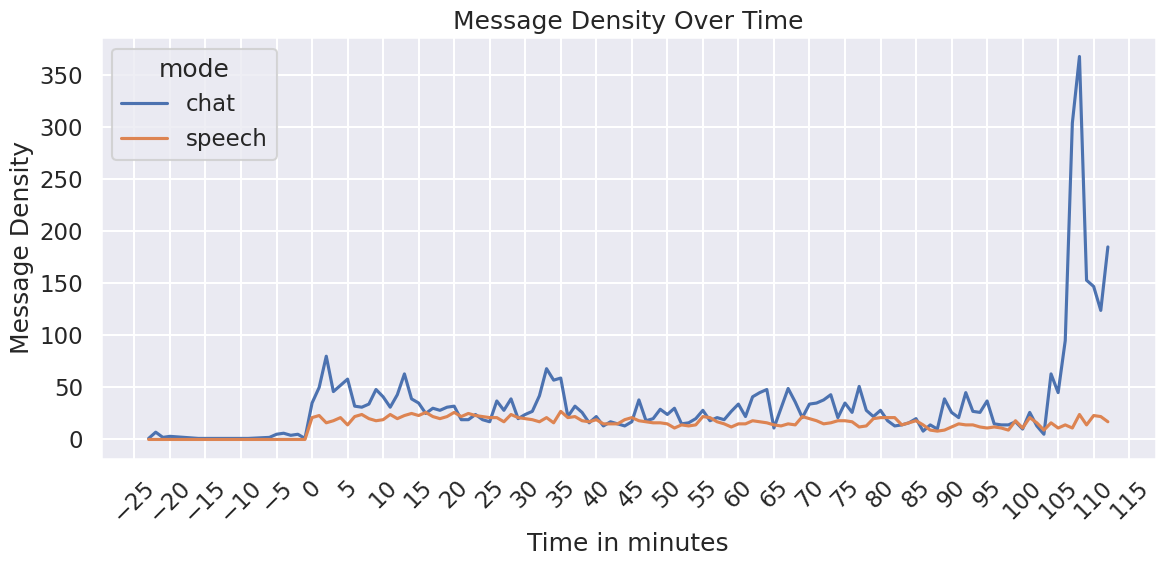

In [18]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=result_df2, x='time', y='value', hue='mode')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xlabel('Time in minutes')
plt.ylabel('Message Density')
plt.title('Message Density Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("message_density.png",dpi=600)
plt.show()